<a href="https://colab.research.google.com/github/Gheras13/Homework/blob/main/Homewrok_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MACHINE LEARNING HOMEWORK 1

#DIRECT KINEMATICS OF ROBOT MANIPLUATOR

In [21]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [22]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Generate Data

In [23]:


# Percorso del file CSV
file_path = '/content/drive/My Drive/File_csv/Copia di r2_20_100k.csv'
# Carica il dataset
dataset = pd.read_csv(file_path, sep=';', header=0)

# Rimuovi eventuali spazi dai nomi delle colonne
dataset.columns = dataset.columns.str.strip()
#prendo i primi 1000 samples
df = dataset.iloc[:10000]
# Stampa i nomi delle colonne disponibili
print("Colonne disponibili nel dataset:", df.columns.tolist())

# Estrai le feature (j0, j1) e i target (ee_x, ee_y)
X = df[['j0', 'j1']].values  # Angoli articolari
Y = df[['ee_x', 'ee_y']].values  # Posizioni finali (end-effector)

# Verifica i dati caricati
print("Esempio di X (features):", X[:5])  # Prime 5 righe delle feature
print("Esempio di Y (target):", Y[:5])  # Prime 5 righe del target


Colonne disponibili nel dataset: ['j0', 'j1', 'cos(j0)', 'cos(j1)', 'sin(j0)', 'sin(j1)', 'ee_x', 'ee_y', 'ee_qw', 'ee_qz']
Esempio di X (features): [[-0.044 -0.008]
 [-0.062 -0.011]
 [-0.126 -0.015]
 [-0.226 -0.051]
 [-0.364 -0.082]]
Esempio di Y (target): [[ 0.21  -0.01 ]
 [ 0.21  -0.014]
 [ 0.208 -0.028]
 [ 0.203 -0.053]
 [ 0.193 -0.083]]


In [24]:
# Dividi i dati in training e testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# (Opzionale) Standardizza gli input per migliorare la stabilità numerica
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

Y_train = scaler_Y.fit_transform(Y_train)
Y_test = scaler_Y.transform(Y_test)

# Test del modello

Rete neurale FeedForward con tensorflow

Definisce una rete neurale feedforward in cui i layer sono collegati uno dopo l'altro (architettura sequenziale).
Ogni layer prende in input l'output del layer precedente.

Definizione di una rete neurale feedforward per la cinematica diretta.
 Struttura:
 - Input: 2 caratteristiche (angoli articolari).
 - 3 layer nascosti con attivazione ReLU.
 - Output: 2 caratteristiche (posizione terminale x, y).


In [25]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2)
    ])
    return model


 Configurazione del modello per l'addestramento:
 - Ottimizzatore: Adam (learning_rate=0.01).
 - Funzione di perdita: Mean Squared Error (MSE).
 - Metriche: Mean Absolute Error (MAE).


# Valutazione finale del modello sul set di test.
# Metriche:
# - `loss`: Errore quadratico medio (MSE), risulterà essere la nostra LOSS FUNCTION.
# - `mae`: Errore assoluto medio.
# Come SOLVER è stato scelto ADAM


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3719 - mae: 0.4256 - val_loss: 0.0096 - val_mae: 0.0772
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - mae: 0.0636 - val_loss: 0.0051 - val_mae: 0.0558
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0046 - mae: 0.0528 - val_loss: 0.0079 - val_mae: 0.0707
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - mae: 0.0560 - val_loss: 0.0044 - val_mae: 0.0515
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - mae: 0.0680 - val_loss: 0.0085 - val_mae: 0.0686
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - mae: 0.0525 - val_loss: 0.0027 - val_mae: 0.0398
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - mae: 0.0382 - val_loss: 0.0050 - val_mae: 0.0525
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0423 - val_loss: 0.0029 - val_mae: 0.0403
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0025 

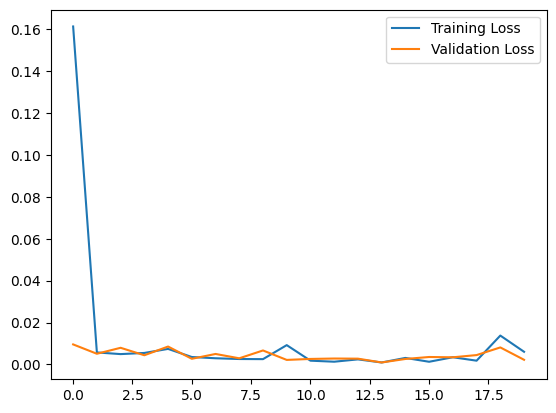

In [26]:
# Costruzione e compilazione del modello
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

# Addestramento
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)

# Valutazione sul test set
loss, mae = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Traccia l'andamento della perdita
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [29]:
from itertools import product

hidden_layers = [64, 128]
learning_rates = [0.01, 0.001]

results = []

for hl, lr in product(hidden_layers, learning_rates):
    print(f"Testing model with {hl} hidden neurons and {lr} learning rate")

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hl, activation='relu', input_shape=(2,)),
        tf.keras.layers.Dense(hl, activation='relu'),
        tf.keras.layers.Dense(2)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=0)
    loss, mae = model.evaluate(X_test, Y_test, verbose=0)
    results.append((hl, lr, loss, mae))

# Riporta i risultati migliori
for res in results:
    print(f"Hidden Neurons: {res[0]}, Learning Rate: {res[1]}, Loss: {res[2]}, MAE: {res[3]}")


Testing model with 64 hidden neurons and 0.01 learning rate
Testing model with 64 hidden neurons and 0.001 learning rate
Testing model with 128 hidden neurons and 0.01 learning rate
Testing model with 128 hidden neurons and 0.001 learning rate
Hidden Neurons: 64, Learning Rate: 0.01, Loss: 0.004027106799185276, MAE: 0.050010066479444504
Hidden Neurons: 64, Learning Rate: 0.001, Loss: 0.0017180793220177293, MAE: 0.030746856704354286
Hidden Neurons: 128, Learning Rate: 0.01, Loss: 0.0007265559979714453, MAE: 0.020902294665575027
Hidden Neurons: 128, Learning Rate: 0.001, Loss: 0.0015914376126602292, MAE: 0.03198453038930893


#Definizione dei jacobiani

In [27]:
@tf.function
def FK_Jacobian(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = FK(model, x)  # Forward pass
    return tape.jacobian(y, x)

def FK(model, theta):
    # Reshape to batch size 1
    t = tf.reshape(theta, shape=(1, 2))
    out = model(t)
    # Reshape to 1d vector
    out = tf.reshape(out, shape=(2,))
    return out

def analytical_J(theta, L1=1.0, L2=1.0):
    j0, j1 = theta
    J = np.array([
        [-L1 * np.sin(j0) - L2 * np.sin(j0 + j1), -L2 * np.sin(j0 + j1)],
        [L1 * np.cos(j0) + L2 * np.cos(j0 + j1),  L2 * np.cos(j0 + j1)]
    ])
    return J


In [28]:
# Esempio di confronto
theta_sample = X_test[0]  # Primo esempio di test
jacobian_learned = FK_Jacobian(model, tf.convert_to_tensor([theta_sample], dtype=tf.float32))
jacobian_analytical = analytical_J(theta_sample)

print("Jacobiana appresa:\n", jacobian_learned.numpy())
print("Jacobiana analitica:\n", jacobian_analytical)


Jacobiana appresa:
 [[[ 1.2406592  2.8094797]]

 [[-1.2697632  0.1887255]]]
Jacobiana analitica:
 [[-1.67888275 -0.79993196]
 [-0.12317826 -0.60009072]]
